INFO:main:

 processing image 	 dataset/images_test/no4.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (133, 69)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x69
DEBUG:main:Template 'template_yes.PNG' match value: -0.05860821530222893
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 129x76
DEBUG:main:Template 'template_no.PNG' match value: 0.8988000154495239


dataset/images_test


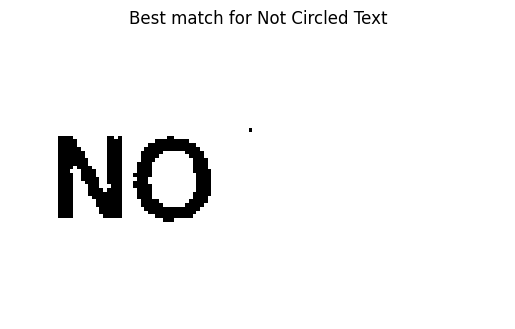

DEBUG:main:Resized template 'template_yes_check.PNG' to (133, 67)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x67
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.07184271514415741
DEBUG:main:Resized template 'template_no_check.PNG' to (133, 74)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x74
DEBUG:main:Template 'template_no_check.PNG' match value: 0.5589603185653687
DEBUG:main:Resized template 'template_yes_check_hand.PNG' to (133, 72)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x72
DEBUG:main:Template 'template_yes_check_hand.PNG' match value: 0.018231233581900597
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 132x76
DEBUG:main:Template 'template_no_check_hand.PNG' match value: 0.351120263338089


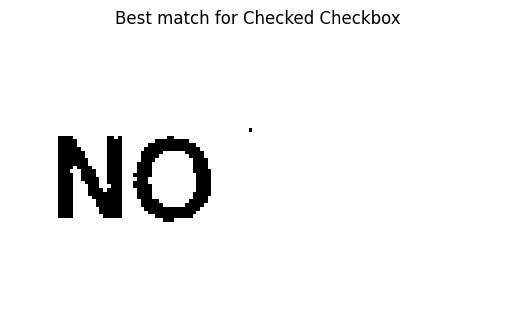

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (133, 66)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x66
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.02788095735013485
DEBUG:main:Resized template 'template_no_uncheck.PNG' to (133, 75)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x75
DEBUG:main:Template 'template_no_uncheck.PNG' match value: 0.34128400683403015


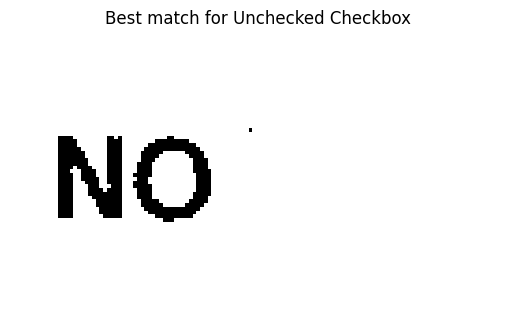

DEBUG:main:No circles detected around text.
INFO:main:{'confidence': 89.88000154495239, 'final_result': True, 'test_performed': 'not_circled', 'all_attempts': {'not_circled': {'detected': True, 'confidence': 89.88000154495239, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 55.896031856536865, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': False, 'confidence': 34.128400683403015, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': False, 'confidence': 0, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 0, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no4_annotated.png


In [57]:
import importlib
import main
import os
importlib.reload(main)
from main import *
folder = "dataset/images_test"


def list_files_in_folder(folder_path, ext=None):
    """
    Returns a list of file names in the given folder, optionally filtering by extension.
    
    Parameters:
        folder_path (str): The path to the folder.
        ext (str, optional): The file extension to filter by (e.g., 'png'). Defaults to None.
        
    Returns:
        list: A list of file names matching the extension.
    """
    try:
        # List all files in the directory
        files = [
            f for f in os.listdir(folder_path)
            if os.path.isfile(os.path.join(folder_path, f))
        ]
        
        if ext is not None:
            # Normalize the extension to lowercase
            ext = ext.lower()
            # Filter files by extension (case-insensitive)
            files = [
                f for f in files
                if os.path.splitext(f)[1].lower() == f'.{ext}'
            ]
        
        return files
    
    except FileNotFoundError:
        print(f"The folder '{folder_path}' does not exist.")
        return []
    except PermissionError:
        print(f"Permission denied to access '{folder_path}'.")
        return []
    



threshold = 60  # Set your desired threshold


 
image_paths = list_files_in_folder(folder,ext="PNG")

print(folder)
for file_name in image_paths:
    full_file_path = os.path.join(folder, file_name)

    filename = full_file_path.split("/")[-1]
    name = filename.split(".")[0]


    # break    
    # if name in ["no1_93","no1_86","yes1_2"] :
    # if name in ["no1_93","no1_86","no1_96","no1_97","yes1_2","yes1_79","no1_27"] :
    # if name in ["yes1_79"] :
    # if name in ["no1_27"] :
    # if name in ["no1_93"] :
    # if name in ["no1_2"] :
    if name in ["no4"] :
    # if name in ["no1_27"] or 1:

        original = image.copy()
        result_payload = process_image(full_file_path, threshold=threshold, show_plots=True)
        LOGGER.info(result_payload)



        # Save the resulting images with green or red text
        output_directory = 'results'
        file_name_prefix = os.path.splitext(os.path.basename(filename))[0]  # Use the original file name as prefix

        annotated_image_path = annotate_image(
            image=image,
            result_payload=result_payload,
            output_path=output_directory,
            file_name_prefix=file_name_prefix,
        )

        

In [ ]:
# epsilon_values = [0.01, 0.02, 0.03, 0.05]

# for epsilon_multiplier in epsilon_values:
#     print(f"\nTesting with epsilon_multiplier = {epsilon_multiplier}")
#     tick_detected, detection_info = detect_checkbox_with_tick(
#         gray,
#         area_threshold=100,
#         epsilon_multiplier=epsilon_multiplier,
#         debug=True,
#         show_plots=True
#     )

In [ ]:
# param_ranges = {
#     'clahe_clip_limits': [1.0, 1.5, 2.0],
#     'tile_grid_sizes': [(4, 4), (8, 8)],
#     'block_sizes': [15, 21, 31],  # Must be odd numbers
#     'C_values': [2, 3, 5],
#     'area_thresholds': [50, 100, 200]
# }
# full_file_path = "dataset/images_test/no1_93.PNG"
# explore_detection_parameters(full_file_path, param_ranges)